In [1]:
import itertools
import sys, os

import numpy as np
import pandas as pd
from scipy.special import comb
from scipy import stats
import scipy.cluster.hierarchy as hac
import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns

from collections import Counter
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

sns.set(rc={'figure.figsize':(15,8)})
sns.set_context('poster')

In [2]:
%load_ext autoreload
%autoreload 2
#import CCPA_lib as cp
import sorf_lib as sf

In [3]:
sns.set_context('talk')
sns.set_style('white')


![](http://oregonstate.edu/instruct/bb450/fall14/stryer7/2/table_02_02.jpg)

https://www.uniprot.org/uniprot/Q7V735

http://tigrfams.jcvi.org/cgi-bin/HmmReportPage.cgi?acc=TIGR03798

https://www.ebi.ac.uk/training/online/course/interpro-functional-and-structural-analysis-protei/sequence-searching/searching-interpro-batc

http://www.ebi.ac.uk/interpro/sequencesearch/iprscan5-S20190707-131508-0462-76111813-p1m

https://www.ebi.ac.uk/Tools/services/rest/iprscan5/result/iprscan5-S20190707-131508-0462-76111813-p1m/json

In [4]:
oorder = ['Intergenic', 'Antisense', 'Out of Frame','In Frame',  'Annotated', ]
opalette = sns.color_palette("rainbow", 5).as_hex()
#del opalette[4]
genome='MIT9313'

In [5]:
found_sorf_df = pd.read_pickle('found_sorf_ISME16_David.pkl.gz')

In [6]:
found_sorf_df.drop_duplicates(subset='orfid', inplace=True)

# Gene Families

In [7]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(found_sorf_df['product'].value_counts())

hypothetical protein                                                  62
Nif11-like leader peptide family natural product precursor            17
                                                                      12
high light inducible protein                                           4
DUF4278 domain-containing protein                                      2
4a-hydroxytetrahydrobiopterin dehydratase                              2
bacteriocin                                                            2
sulfurtransferase TusA family protein                                  1
Asp-tRNA(Asn)/Glu-tRNA(Gln) amidotransferase subunit GatC              1
DUF3721 domain-containing protein                                      1
DUF2079 domain-containing protein                                      1
glutaredoxin 3                                                         1
BolA family transcriptional regulator                                  1
2Fe-2S iron-sulfur cluster binding domain-containin

In [8]:
found_sorf_df['family2'] = found_sorf_df['family']
found_sorf_df.loc[found_sorf_df['product'].str.contains('ribosomal'), 'family2'] = 'ribosomal'
found_sorf_df.loc[found_sorf_df['product'].str.contains('photosystem'), 'family2'] = 'photosystem'
found_sorf_df.loc[found_sorf_df['product'].str.contains('hypothetical'), 'family2'] = 'hypothetical'
found_sorf_df.loc[found_sorf_df['product'] == '', 'family2'] = 'N/A'
found_sorf_df.loc[found_sorf_df['product'].str.contains('domain-containing protein') &
                  found_sorf_df['product'].str.startswith('DUF') , 'family2'] = 'DUF'
found_sorf_df.loc[found_sorf_df['product'].str.contains('family protein') &
                  found_sorf_df['product'].str.startswith('DUF') , 'family2'] = 'DUF'
found_sorf_df.loc[found_sorf_df['product'].str.contains('high light inducible protein'), 'family2'] = 'HLIP'
found_sorf_df.loc[found_sorf_df['product'].str.contains('carboxysome'), 'family2'] = 'carboxysome'
found_sorf_df.loc[found_sorf_df['family2'].isna(), 'family2'] = 'other'
found_sorf_df.loc[~found_sorf_df['family'].isna(), 'family2'] = found_sorf_df.loc[~found_sorf_df['family'].isna(), 'family']


In [9]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.max_colwidth', 100000):  # more options can be specified also
    #display(found_sorf_df.loc[found_sorf_df.family2.isna(), 'product'].value_counts())    
    display(found_sorf_df.loc[found_sorf_df.family2.isna(), 'product'].sort_values().reset_index(drop=True))

Series([], Name: product, dtype: object)

In [10]:
found_sorf_df.groupby(['family2'])['product'].value_counts()

family2    product                          
CCRG-2     CCRG-2 family RiPP                   1
           hypothetical protein                 1
DUF        DUF4278 domain-containing protein    2
           DUF2079 domain-containing protein    1
           DUF2470 domain-containing protein    1
                                               ..
ribosomal  50S ribosomal protein L28            1
           50S ribosomal protein L29            1
           50S ribosomal protein L31            1
           50S ribosomal protein L32            1
           50S ribosomal protein L33            1
Name: product, Length: 67, dtype: int64

In [11]:
found_sorf_df.loc[found_sorf_df['family2'] == 'other']['product'].value_counts()

bacteriocin                                                           2
4a-hydroxytetrahydrobiopterin dehydratase                             2
ATP-dependent Clp protease adapter ClpS                               1
rubredoxin                                                            1
sulfurtransferase TusA family protein                                 1
NifU family protein                                                   1
sulfur carrier protein ThiS                                           1
cytochrome b559 subunit alpha                                         1
UDP-2,4-diacetamido-2,4, 6-trideoxy-beta-L-altropyranose hydrolase    1
chlororespiratory reduction protein 7                                 1
HU family DNA-binding protein                                         1
chemotaxis protein                                                    1
RNA-binding S4 domain-containing protein                              1
cytochrome b559 subunit beta                                    

# BLAST vs SORFS

In [12]:
def is_in_found_sorf(r):
    orfid = r.id.replace('lcl|','')
    return found_sorf_df.orfid.isin([orfid]).sum() > 0
    

In [13]:
accession = sf.get_accession(genome)
orf_dpath = 'orffinder_tmp'
orf_fpath = os.path.join(orf_dpath, f'{accession}.orffinder.fa')

In [14]:
from Bio import SeqIO
records = (r for r in SeqIO.parse(orf_fpath, "fasta") if is_in_found_sorf(r))

In [15]:
out_fpath = os.path.join(orf_dpath, f'{genome}_found_proteome.fasta')
count = SeqIO.write(records, out_fpath, "fasta")
print("Saved %i records from %s to %s" % (count, orf_fpath, out_fpath))

Saved 160 records from orffinder_tmp\BX548175.orffinder.fa to orffinder_tmp\MIT9313_found_proteome.fasta


 mit9313_found_vs_pro_syn    https://blast.ncbi.nlm.nih.gov/Blast.cgi?CMD=Get&RID=8P2ACMPV014    
 mit9313_found_vs_nr         https://blast.ncbi.nlm.nih.gov/Blast.cgi?CMD=Get&RID=8P26YCM7014
 mit9313_found_vs_swisprot   https://blast.ncbi.nlm.nih.gov/Blast.cgi?CMD=Get&RID=8SHSH1FU014
 

In [16]:
blast_dpath = os.path.join('orffinder_tmp','blast results')
blast_vs_nr_dpath = os.path.join(blast_dpath, 'mit9313_found_vs_nr-Alignment.xml')
blast_vs_pro_dpath = os.path.join(blast_dpath, 'mit9313_found_vs_pro_syn-Alignment.xml')
blastn_vs_pro_dpath = os.path.join(blast_dpath, 'mit9313_blastn_vs_pro_syn-Alignment.xml')

blast_vs_sorf_dpath = os.path.join(blast_dpath, 'mit9313_sorf_all_vs_all-Alignment.xml')
blast_vs_swisprot_dpath = os.path.join(blast_dpath, 'mit9313_found_vs_swisprot-Alignment.xml')

os.listdir(blast_dpath)

['mit9313_blastn_vs_pro_syn-Alignment.xml',
 'mit9313_found_vs_pro_syn-Alignment.xml',
 'mit9313_found_vs_swisprot-Alignment.xml',
 'mit9313_sorf_all_vs_all-Alignment.xml',
 'old']

In [17]:
from Bio.Blast import NCBIXML


# BLAST vs SORF

In [18]:
def blast_rec_to_dict(blast_rec):
    query_id = blast_rec.query.replace(' unnamed protein product','').replace('lcl|','')
    results = [{
        'query' : query_id,
        'aligment_id' : alignment.hit_def.split()[0].replace('lcl|', ''), 
        'alignment_def' : alignment.hit_def,
        'coverage': np.round(np.mean([hsp.align_length / blast_rec.query_length for hsp in alignment.hsps]), decimals=2),
        'identity': np.round(np.mean([hsp.identities / blast_rec.query_length for hsp in alignment.hsps]), decimals=2),
        
        }
        for alignment in blast_rec.alignments if alignment.hit_id != query_id
    ]
    return results

In [19]:
fh = open(blast_vs_sorf_dpath)
blast_records = NCBIXML.parse(fh)
reslist = [blast_rec_to_dict(b) for b in blast_records]
blast_vs_sorf_df = pd.DataFrame([i for lst in reslist for i in lst])

In [20]:
fh.close()

In [21]:
for query in blast_records:
    for alignment in query.alignments:
        for hsp in alignment.hsps:
            print('coverage', hsp.align_length / query.query_length)
            print('identitiy', hsp.identities/ hsp.align_length)

In [22]:
blast_vs_sorf_df.head()

,query,aligment_id,alignment_def,coverage,identity
0,ORF59_BX548175.1:26835:27080,ORF59_BX548175.1:26835:27080,lcl|ORF59_BX548175.1:26835:27080 unnamed prote...,1.00,1.00
1,ORF395_BX548175.1:178002:178226,ORF395_BX548175.1:178002:178226,lcl|ORF395_BX548175.1:178002:178226 unnamed pr...,1.00,1.00
2,ORF2049_BX548175.1:913137:913382,ORF2049_BX548175.1:913137:913382,lcl|ORF2049_BX548175.1:913137:913382 unnamed p...,1.00,1.00
3,ORF2049_BX548175.1:913137:913382,ORF18399_BX548175.1:1009005:1008772,lcl|ORF18399_BX548175.1:1009005:1008772 unname...,0.98,0.80
4,ORF2049_BX548175.1:913137:913382,ORF26372_BX548175.1:2236618:2236379,lcl|ORF26372_BX548175.1:2236618:2236379 unname...,0.93,0.75


In [23]:
def create_sorfs_cluster(blast_vs_sorf_df, cluster_sorfs):
    new_alignments = set(
        blast_vs_sorf_df.loc[blast_vs_sorf_df['query'].isin(cluster_sorfs), 'aligment_id'].unique()
    )
    new_queries = set(
        blast_vs_sorf_df.loc[blast_vs_sorf_df['aligment_id'].isin(cluster_sorfs), 'query'].unique()
    )
    if (new_alignments <= cluster_sorfs) and (new_queries <= cluster_sorfs):
        return cluster_sorfs
    else:
        new_cluster_sorfs = cluster_sorfs | new_alignments | new_queries
        return create_sorfs_cluster(blast_vs_sorf_df, new_cluster_sorfs)
    
    

In [24]:
def create_sorfs_cluster_sel_root(blast_vs_sorf_df, visited):
    not_visited = blast_vs_sorf_df.loc[~blast_vs_sorf_df['query'].isin(visited), 'query'].unique()
    if len(not_visited):
        return create_sorfs_cluster(blast_vs_sorf_df, {not_visited[0]})
    #else
    not_visited2 = blast_vs_sorf_df.loc[~blast_vs_sorf_df['aligment_id'].isin(visited), 'aligment_id'].unique()
    if len(not_visited2):
        return create_sorfs_cluster(blast_vs_sorf_df, {not_visited2[0]})
    # else
    return None
    


In [25]:
visited = set()
clusters = []
while(True):
    new_cluster = create_sorfs_cluster_sel_root(blast_vs_sorf_df, visited)
    if new_cluster is None:
        break
    visited = visited | new_cluster
    clusters.append(new_cluster)
    

In [26]:
len(clusters)

133

In [27]:
clusters

[{'ORF59_BX548175.1:26835:27080'},
 {'ORF395_BX548175.1:178002:178226'},
 {'ORF15620_BX548175.1:2243295:2243047',
  'ORF15637_BX548175.1:2235903:2235652',
  'ORF15638_BX548175.1:2235486:2235229',
  'ORF15639_BX548175.1:2235150:2234896',
  'ORF18399_BX548175.1:1009005:1008772',
  'ORF20045_BX548175.1:274995:274750',
  'ORF2049_BX548175.1:913137:913382',
  'ORF20960_BX548175.1:2244944:2244663',
  'ORF20982_BX548175.1:2236277:2236026',
  'ORF25353_BX548175.1:276446:276159',
  'ORF25455_BX548175.1:233492:233262',
  'ORF26353_BX548175.1:2243725:2243456',
  'ORF26370_BX548175.1:2237020:2236769',
  'ORF26372_BX548175.1:2236618:2236379',
  'ORF29176_BX548175.1:1009423:1009181',
  'ORF30806_BX548175.1:274552:274289',
  'ORF5422_BX548175.1:182116:182298',
  'ORF7032_BX548175.1:905452:905715'},
 {'ORF2068_BX548175.1:922530:922661'},
 {'ORF18490_BX548175.1:968157:967891', 'ORF2321_BX548175.1:1030986:1031147'},
 {'ORF2340_BX548175.1:1038120:1038374'},
 {'ORF2353_BX548175.1:1042338:1042538'},
 {'ORF

In [28]:
real_clusters = [i for i in clusters if len(i)>1]
for i,c in enumerate(real_clusters, start=1):
    found_sorf_df.loc[found_sorf_df.orfid.isin(c), 'cluster_id'] = i

In [29]:
len(real_clusters)

7

In [30]:
found_sorf_df.head()

,orfid,contig,left,right,start,stop,strand,aaseq,len_nn,len_aa,...,Coverage,AAs,short,multiple unique peptides,has unique peptides,ms_detected,is_found_technion,status,family2,cluster_id
57,ORF59_BX548175.1:26835:27080,BX548175.1,26835,27080,26835,27080,+,MTAQLVPDQQIDLRGTPCPINFIRCRLALEGLKDKERLQVDLDRGE...,246,81,...,41.97,81.0,True,True,True,True,False,"Detected, new",other,NaN
409,ORF395_BX548175.1:178002:178226,BX548175.1,178002,178226,178002,178226,+,MKRLGYPLLSLAAPLLIVLAMLCLMHRQGSDRLQSIPAVLVGAGLI...,225,74,...,20.27,74.0,True,True,True,True,False,"Detected, new",DUF,NaN
2286,ORF2049_BX548175.1:913137:913382,BX548175.1,913137,913382,913137,913382,+,MSEEQLKAFIAKVQGDTSLQEQLKAEGADVVAIAKAAGFSITTEDL...,246,81,...,35.80,81.0,True,True,True,True,True,Detected,ProcA,1.0
2317,ORF2068_BX548175.1:922530:922661,BX548175.1,922530,922661,922530,922661,+,MMGKTKQHKKLVSWAEKAELCATREEAQKLIRKAEKAHAKLES,132,43,...,27.91,43.0,True,False,True,True,True,Detected,N/A,NaN
2647,ORF2321_BX548175.1:1030986:1031147,BX548175.1,1030986,1031147,1030986,1031147,+,MLSKSITGMFGRRNKKDAPKEEPTETDLERGYRLAAAKQKEILKEL...,162,53,...,58.49,53.0,True,True,True,True,True,Detected,N/A,2.0


In [31]:
found_sorf_df.groupby(['cluster_id','family2'])['product'].value_counts()

cluster_id  family2       product                                                   
1.0         ProcA         Nif11-like leader peptide family natural product precursor    17
                          lantipeptide                                                   1
2.0         N/A                                                                          1
            hypothetical  hypothetical protein                                           1
3.0         hypothetical  hypothetical protein                                           2
4.0         HLIP          high light inducible protein                                   3
            other         ssl1498 family light-harvesting-like protein                   1
5.0         hypothetical  hypothetical protein                                           2
6.0         CCRG-2        CCRG-2 family RiPP                                             1
                          hypothetical protein                                           1
     

In [32]:
found_sorf_df.groupby(['cluster_id', 'otype', 'orfid', 'product', #'family'
                      ])['family'].unique().str.join(',').reset_index()

,cluster_id,otype,orfid,product,family
0,1.0,Annotated,ORF15620_BX548175.1:2243295:2243047,Nif11-like leader peptide family natural produ...,ProcA
1,1.0,Annotated,ORF15637_BX548175.1:2235903:2235652,Nif11-like leader peptide family natural produ...,ProcA
2,1.0,Annotated,ORF15638_BX548175.1:2235486:2235229,lantipeptide,ProcA
3,1.0,Annotated,ORF15639_BX548175.1:2235150:2234896,Nif11-like leader peptide family natural produ...,ProcA
4,1.0,Annotated,ORF18399_BX548175.1:1009005:1008772,Nif11-like leader peptide family natural produ...,ProcA
5,1.0,Annotated,ORF20045_BX548175.1:274995:274750,Nif11-like leader peptide family natural produ...,ProcA
6,1.0,Annotated,ORF2049_BX548175.1:913137:913382,Nif11-like leader peptide family natural produ...,ProcA
7,1.0,Annotated,ORF20960_BX548175.1:2244944:2244663,Nif11-like leader peptide family natural produ...,ProcA
8,1.0,Annotated,ORF20982_BX548175.1:2236277:2236026,Nif11-like leader peptide family natural produ...,ProcA
9,1.0,Annotated,ORF25353_BX548175.1:276446:276159,Nif11-like leader peptide family natural produ...,ProcA


In [33]:
found_sorf_df.loc[found_sorf_df.cluster_id.isna()]['otype'].value_counts()

Annotated     110
Intergenic     11
Antisense       5
Name: otype, dtype: int64

In [34]:
found_sorf_df.pivot_table(columns='otype', index='family2',aggfunc='count', values='orfid').sum()


otype
Annotated       142.0
Antisense         5.0
Intergenic       12.0
Out of Frame      1.0
dtype: float64

In [35]:
found_sorf_df.otype.value_counts()

Annotated       142
Intergenic       12
Antisense         5
Out of Frame      1
Name: otype, dtype: int64

# tBLASTn vs PRO /SYN genomes

In [36]:
def pro_blastn_to_description(blast_rec):
    query_id = blast_rec.query.replace(' unnamed protein product','').replace('lcl|','')
    results = [{
        'query' : query_id,
        'pro_syn' : a.hit_def,
        'pro_syn_accession' : d.accession,
        'pro_syn_hsps' : len(a.hsps),
        'pro_syn_coverage': np.round(np.mean([hsp.align_length / blast_rec.query_length for hsp in a.hsps]), decimals=2),
        'pro_syn_identity': np.round(np.mean([hsp.identities / blast_rec.query_length for hsp in a.hsps]), decimals=2),
        }
        for d,a in zip(blast_rec.descriptions, blast_rec.alignments)
    ]
    return results

In [37]:
fh = open(blastn_vs_pro_dpath)
blast_records = NCBIXML.parse(fh)
reslist = [pro_blastn_to_description(b) for b in blast_records]
blastn_vs_pro_df = pd.DataFrame([i for lst in reslist for i in lst])

In [38]:
fh.close()

In [39]:
blastn_vs_pro_df.head()

,query,pro_syn,pro_syn_accession,pro_syn_hsps,pro_syn_coverage,pro_syn_identity
0,ORF59_BX548175.1:26835:27080,Prochlorococcus marinus MIT9313 complete genome,BX548175,1,1.00,1.00
1,ORF59_BX548175.1:26835:27080,"Prochlorococcus marinus str. MIT 9303, complet...",CP000554,1,1.00,0.99
2,ORF59_BX548175.1:26835:27080,"Synechococcus sp. CC9311, complete genome",CP000435,1,0.93,0.57
3,ORF59_BX548175.1:26835:27080,Synechococcus sp. WH 8020 genome,CP011941,1,0.91,0.58
4,ORF59_BX548175.1:26835:27080,Synechococcus sp. WH8102 complete genome; segm...,BX569689,1,0.89,0.57


In [40]:
grouped_blastn_vs_pro_df =  blastn_vs_pro_df.loc[
    ~blastn_vs_pro_df.pro_syn.str.contains('MIT9313')
    ].groupby(by='query').agg({'pro_syn': 'count', 'pro_syn_hsps': 'mean'}).reset_index()
grouped_blastn_vs_pro_df.rename(columns={
    'pro_syn': 'pro/syn genomes', 
    'pro_syn_hsps': 'mean pro/syn alignments', 
    'pro_syn_coverage': 'mean pro/syn coverage',
    'pro_syn_identity': 'mean pro/syn identity'},
                                inplace=True)

In [41]:
grouped_blastn_vs_9313_df =  blastn_vs_pro_df.loc[
    blastn_vs_pro_df.pro_syn.str.contains('MIT9313')
    ].groupby(by='query').agg({'pro_syn': 'count', 'pro_syn_hsps': 'mean'}).reset_index()
grouped_blastn_vs_9313_df.rename(columns={
    'pro_syn': 'mit9313', 
    'pro_syn_hsps': 'mit9313 alignments',
    'pro_syn_coverage': 'mean mit9313 coverage',
    'pro_syn_identity': 'mean mit9313 identity'},
                                inplace=True)

In [42]:
found_sorf_df = pd.merge(found_sorf_df, 
         grouped_blastn_vs_pro_df,
         left_on='orfid', right_on='query', how='left')

In [43]:
found_sorf_df = pd.merge(found_sorf_df, 
         grouped_blastn_vs_9313_df,
         left_on='orfid', right_on='query', how='left')

In [44]:
found_sorf_df.head()

,orfid,contig,left,right,start,stop,strand,aaseq,len_nn,len_aa,...,is_found_technion,status,family2,cluster_id,query_x,pro/syn genomes,mean pro/syn alignments,query_y,mit9313,mit9313 alignments
0,ORF59_BX548175.1:26835:27080,BX548175.1,26835,27080,26835,27080,+,MTAQLVPDQQIDLRGTPCPINFIRCRLALEGLKDKERLQVDLDRGE...,246,81,...,False,"Detected, new",other,NaN,ORF59_BX548175.1:26835:27080,52.0,1.0,ORF59_BX548175.1:26835:27080,1.0,1.0
1,ORF395_BX548175.1:178002:178226,BX548175.1,178002,178226,178002,178226,+,MKRLGYPLLSLAAPLLIVLAMLCLMHRQGSDRLQSIPAVLVGAGLI...,225,74,...,False,"Detected, new",DUF,NaN,ORF395_BX548175.1:178002:178226,7.0,1.0,ORF395_BX548175.1:178002:178226,1.0,1.0
2,ORF2049_BX548175.1:913137:913382,BX548175.1,913137,913382,913137,913382,+,MSEEQLKAFIAKVQGDTSLQEQLKAEGADVVAIAKAAGFSITTEDL...,246,81,...,True,Detected,ProcA,1.0,ORF2049_BX548175.1:913137:913382,5.0,12.0,ORF2049_BX548175.1:913137:913382,1.0,34.0
3,ORF2068_BX548175.1:922530:922661,BX548175.1,922530,922661,922530,922661,+,MMGKTKQHKKLVSWAEKAELCATREEAQKLIRKAEKAHAKLES,132,43,...,True,Detected,N/A,NaN,ORF2068_BX548175.1:922530:922661,11.0,1.0,ORF2068_BX548175.1:922530:922661,1.0,1.0
4,ORF2321_BX548175.1:1030986:1031147,BX548175.1,1030986,1031147,1030986,1031147,+,MLSKSITGMFGRRNKKDAPKEEPTETDLERGYRLAAAKQKEILKEL...,162,53,...,True,Detected,N/A,2.0,ORF2321_BX548175.1:1030986:1031147,1.0,3.0,ORF2321_BX548175.1:1030986:1031147,1.0,3.0


# blast vs pro syn

In [45]:
def prosyn_blast_to_description(blast_rec):
    query_id = blast_rec.query.replace(' unnamed protein product','').replace('lcl|','')
    results = [{
        'query' : query_id,
        'pro_syn_description' : d.title.split('=', maxsplit=1)[-1],
        'pro_syn_accession': d.accession,
        'pro_syn_e' : d.e,
        'pro_syn_coverage': np.round(np.mean([hsp.align_length / blast_rec.query_length for hsp in a.hsps]), decimals=2),
        'pro_syn_identity': np.round(np.mean([hsp.identities / blast_rec.query_length for hsp in a.hsps]), decimals=2),
        
        }
        for d,a in zip(blast_rec.descriptions, blast_rec.alignments)
    ]
    return results

In [46]:
fh = open(blast_vs_pro_dpath)
blast_records = NCBIXML.parse(fh)
reslist = [prosyn_blast_to_description(b) for b in blast_records]
blast_vs_pro_df = pd.DataFrame([i for lst in reslist for i in lst])

In [47]:
blast_vs_pro_df.loc[blast_vs_pro_df.pro_syn_description.str.contains('9313')].head()

,query,pro_syn_description,pro_syn_accession,pro_syn_e,pro_syn_coverage,pro_syn_identity
0,ORF59_BX548175.1:26835:27080,ref|WP_011129402.1| MULTISPECIES: sulfurtransf...,WP_011129402,1.956330e-54,1.00,1.00
156,ORF395_BX548175.1:178002:178226,ref|WP_011129537.1| MULTISPECIES: DUF3188 doma...,WP_011129537,1.819970e-46,1.00,1.00
224,ORF2049_BX548175.1:913137:913382,ref|WP_011130214.1| Nif11-like leader peptide ...,WP_011130214,4.329990e-53,1.00,1.00
225,ORF2049_BX548175.1:913137:913382,ref|WP_011130304.1| Nif11-like leader peptide ...,WP_011130304,2.452140e-36,0.98,0.80
229,ORF2049_BX548175.1:913137:913382,ref|WP_011131487.1| Nif11-like leader peptide ...,WP_011131487,1.587080e-35,0.93,0.75


In [48]:
found_sorf_df = pd.merge(found_sorf_df, 
         blast_vs_pro_df.loc[blast_vs_pro_df.groupby('query').pro_syn_e.idxmin()].reset_index(drop=True),
         left_on='orfid', right_on='query', how='left')

In [49]:
found_sorf_df.head()

,orfid,contig,left,right,start,stop,strand,aaseq,len_nn,len_aa,...,mean pro/syn alignments,query_y,mit9313,mit9313 alignments,query,pro_syn_description,pro_syn_accession,pro_syn_e,pro_syn_coverage,pro_syn_identity
0,ORF59_BX548175.1:26835:27080,BX548175.1,26835,27080,26835,27080,+,MTAQLVPDQQIDLRGTPCPINFIRCRLALEGLKDKERLQVDLDRGE...,246,81,...,1.0,ORF59_BX548175.1:26835:27080,1.0,1.0,ORF59_BX548175.1:26835:27080,ref|WP_011129402.1| MULTISPECIES: sulfurtransf...,WP_011129402,1.956330e-54,1.0,1.00
1,ORF395_BX548175.1:178002:178226,BX548175.1,178002,178226,178002,178226,+,MKRLGYPLLSLAAPLLIVLAMLCLMHRQGSDRLQSIPAVLVGAGLI...,225,74,...,1.0,ORF395_BX548175.1:178002:178226,1.0,1.0,ORF395_BX548175.1:178002:178226,ref|WP_011129537.1| MULTISPECIES: DUF3188 doma...,WP_011129537,1.819970e-46,1.0,1.00
2,ORF2049_BX548175.1:913137:913382,BX548175.1,913137,913382,913137,913382,+,MSEEQLKAFIAKVQGDTSLQEQLKAEGADVVAIAKAAGFSITTEDL...,246,81,...,12.0,ORF2049_BX548175.1:913137:913382,1.0,34.0,ORF2049_BX548175.1:913137:913382,ref|WP_011130214.1| Nif11-like leader peptide ...,WP_011130214,4.329990e-53,1.0,1.00
3,ORF2068_BX548175.1:922530:922661,BX548175.1,922530,922661,922530,922661,+,MMGKTKQHKKLVSWAEKAELCATREEAQKLIRKAEKAHAKLES,132,43,...,1.0,ORF2068_BX548175.1:922530:922661,1.0,1.0,ORF2068_BX548175.1:922530:922661,gb|ABM78103.1| Hypothetical protein P9303_1356...,ABM78103,1.427130e-20,1.0,0.93
4,ORF2321_BX548175.1:1030986:1031147,BX548175.1,1030986,1031147,1030986,1031147,+,MLSKSITGMFGRRNKKDAPKEEPTETDLERGYRLAAAKQKEILKEL...,162,53,...,3.0,ORF2321_BX548175.1:1030986:1031147,1.0,3.0,ORF2321_BX548175.1:1030986:1031147,gb|KZR65522.1| hypothetical protein PMIT1306_0...,KZR65522,5.024540e-32,1.0,1.00


# blast vs swisprot

In [50]:
def swisprot_blast_to_description(blast_rec):
    query_id = blast_rec.query.replace(' unnamed protein product','').replace('lcl|','')
    results = [{
        'query' : query_id,
        'swis_description' : d.title.split('=', maxsplit=1)[-1],
        'swis_e' : d.e,
        'swis_coverage': np.round(np.mean([hsp.align_length / blast_rec.query_length for hsp in a.hsps]), decimals=2),
        'swis_identity': np.round(np.mean([hsp.identities / blast_rec.query_length for hsp in a.hsps]), decimals=2),
        
        }
        for d,a in zip(blast_rec.descriptions, blast_rec.alignments)
    ]
    return results

In [51]:
fh = open(blast_vs_swisprot_dpath)
blast_records = NCBIXML.parse(fh)
reslist = [swisprot_blast_to_description(b) for b in blast_records]
blast_vs_swis_df = pd.DataFrame([i for lst in reslist for i in lst])

In [52]:
found_sorf_df = pd.merge(found_sorf_df, 
         blast_vs_swis_df.loc[blast_vs_swis_df.groupby('query').swis_e.idxmin()].reset_index(drop=True),
         left_on='orfid', right_on='query', how='left')

In [53]:
found_sorf_df.otype.value_counts()

Annotated       142
Intergenic       12
Antisense         5
Out of Frame      1
Name: otype, dtype: int64

In [54]:
found_sorf_df.dropna(subset=['swis_description']).otype.value_counts()

Annotated    39
Name: otype, dtype: int64

In [55]:
found_sorf_df.shape

(160, 94)

# Analysis

In [56]:
[(i,len(j)) for i,j in enumerate(real_clusters, start=1)]

[(1, 18), (2, 2), (3, 2), (4, 4), (5, 2), (6, 4), (7, 2)]

In [57]:
found_sorf_df.groupby(['cluster_id','family2'])['product'].value_counts()

cluster_id  family2       product                                                   
1.0         ProcA         Nif11-like leader peptide family natural product precursor    17
                          lantipeptide                                                   1
2.0         N/A                                                                          1
            hypothetical  hypothetical protein                                           1
3.0         hypothetical  hypothetical protein                                           2
4.0         HLIP          high light inducible protein                                   3
            other         ssl1498 family light-harvesting-like protein                   1
5.0         hypothetical  hypothetical protein                                           2
6.0         CCRG-2        CCRG-2 family RiPP                                             1
                          hypothetical protein                                           1
     

In [58]:
found_sorf_df.loc[found_sorf_df.cluster_id.isna() & ~found_sorf_df.family2.isin(['other'])].groupby(['family2'])['product'].value_counts()

family2       product                                      
DUF           DUF4278 domain-containing protein                 2
              DUF2079 domain-containing protein                 1
              DUF2470 domain-containing protein                 1
              DUF2555 domain-containing protein                 1
              DUF2839 domain-containing protein                 1
              DUF2862 domain-containing protein                 1
              DUF2949 domain-containing protein                 1
              DUF2973 domain-containing protein                 1
              DUF3136 domain-containing protein                 1
              DUF3148 domain-containing protein                 1
              DUF3181 family protein                            1
              DUF3188 domain-containing protein                 1
              DUF3721 domain-containing protein                 1
              DUF3764 family protein                            1
HLIP          hi

In [59]:
found_sorf_df.loc[found_sorf_df.cluster_id.isna() & found_sorf_df.family2.isin(['other'])]['product'].value_counts()

4a-hydroxytetrahydrobiopterin dehydratase                             2
ATP-dependent Clp protease adapter ClpS                               1
HU family DNA-binding protein                                         1
cytochrome b559 subunit beta                                          1
2Fe-2S iron-sulfur cluster binding domain-containing protein          1
NAD(P)H-quinone oxidoreductase subunit O                              1
translation initiation factor IF-1                                    1
rubredoxin                                                            1
Asp-tRNA(Asn)/Glu-tRNA(Gln) amidotransferase subunit GatC             1
sulfurtransferase TusA family protein                                 1
guanylate-binding protein                                             1
chemotaxis protein                                                    1
RNA-binding S4 domain-containing protein                              1
CbiX/SirB N-terminal domain-containing protein                  

In [60]:
found_sorf_df.loc[found_sorf_df.family2.isin(['other']), 'product'].value_counts()

bacteriocin                                                           2
4a-hydroxytetrahydrobiopterin dehydratase                             2
ATP-dependent Clp protease adapter ClpS                               1
rubredoxin                                                            1
sulfurtransferase TusA family protein                                 1
NifU family protein                                                   1
sulfur carrier protein ThiS                                           1
cytochrome b559 subunit alpha                                         1
UDP-2,4-diacetamido-2,4, 6-trideoxy-beta-L-altropyranose hydrolase    1
chlororespiratory reduction protein 7                                 1
HU family DNA-binding protein                                         1
chemotaxis protein                                                    1
RNA-binding S4 domain-containing protein                              1
cytochrome b559 subunit beta                                    

In [61]:
pd.set_option('display.max_colwidth', -1)
found_sorf_df.groupby(['cluster_id', 'otype', 'orfid', 'product', #'swis_description', #'family'
                      ])['family2'].unique().str.join(',').reset_index()

,cluster_id,otype,orfid,product,family2
0,1.0,Annotated,ORF15620_BX548175.1:2243295:2243047,Nif11-like leader peptide family natural product precursor,ProcA
1,1.0,Annotated,ORF15637_BX548175.1:2235903:2235652,Nif11-like leader peptide family natural product precursor,ProcA
2,1.0,Annotated,ORF15638_BX548175.1:2235486:2235229,lantipeptide,ProcA
3,1.0,Annotated,ORF15639_BX548175.1:2235150:2234896,Nif11-like leader peptide family natural product precursor,ProcA
4,1.0,Annotated,ORF18399_BX548175.1:1009005:1008772,Nif11-like leader peptide family natural product precursor,ProcA
5,1.0,Annotated,ORF20045_BX548175.1:274995:274750,Nif11-like leader peptide family natural product precursor,ProcA
6,1.0,Annotated,ORF2049_BX548175.1:913137:913382,Nif11-like leader peptide family natural product precursor,ProcA
7,1.0,Annotated,ORF20960_BX548175.1:2244944:2244663,Nif11-like leader peptide family natural product precursor,ProcA
8,1.0,Annotated,ORF20982_BX548175.1:2236277:2236026,Nif11-like leader peptide family natural product precursor,ProcA
9,1.0,Annotated,ORF25353_BX548175.1:276446:276159,Nif11-like leader peptide family natural product precursor,ProcA


In [62]:
found_sorf_df.loc[found_sorf_df.cluster_id.isna()]['otype'].value_counts()

Annotated     110
Intergenic    11 
Antisense     5  
Name: otype, dtype: int64

In [63]:
found_sorf_df.pivot_table(columns='otype', index='family2',aggfunc='count', values='orfid', margins=True).reset_index()

otype,family2,Annotated,Antisense,Intergenic,Out of Frame,All
0,CCRG-2,2.0,NaN,NaN,NaN,2
1,DUF,14.0,1.0,NaN,NaN,15
2,HLIP,4.0,NaN,NaN,NaN,4
3,N/A,NaN,NaN,12.0,NaN,12
4,ProcA,17.0,NaN,NaN,1.0,18
5,carboxysome,2.0,NaN,NaN,NaN,2
6,hypothetical,59.0,2.0,NaN,NaN,61
7,other,26.0,2.0,NaN,NaN,28
8,photosystem,7.0,NaN,NaN,NaN,7
9,ribosomal,11.0,NaN,NaN,NaN,11


In [64]:
found_sorf_df.otype.value_counts()

Annotated       142
Intergenic      12 
Antisense       5  
Out of Frame    1  
Name: otype, dtype: int64

In [65]:
found_sorf_df.columns

Index(['orfid', 'contig', 'left', 'right', 'start', 'stop', 'strand', 'aaseq',
       'len_nn', 'len_aa', 'len_aa3', 'rast_left', 'rast_right', 'contig_id',
       'gene_id', 'location', 'type', 'start_r', 'stop_r', 'function',
       'figfam', 'nucleotide_sequence', 'aa_sequence', 'genome', 'left_r',
       'right_r', 'overlap_location', 'overlap_strand', 'overlap_gene_type',
       'overlap_count', 'is_same_strand', 'is_out_of_frame', 'is_inside',
       'is_upstream', 'is_downstream', 'overlap_type', 'otype',
       'merge_location', 'contig_id_overlap', 'gene_id_overlap', 'pmt_id',
       'type_overlap', 'location_overlap', 'strand_overlap', 'start_overlap',
       'stop_overlap', 'left_overlap', 'right_overlap', 'function_overlap',
       'genome_overlap', 'old_locus_tag', 'product', 'db_xref', 'protein_id',
       'figfam_overlap', 'nucleotide_sequence_overlap', 'aa_sequence_overlap',
       'family', 'Gene', 'Description', 'log_prob', 'best log prob',
       'best_score', 'total

In [66]:
pd.set_eng_float_format()

In [67]:
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.precision', 0)
found_sorf_df.dropna(subset=['swis_description'])[['family2','otype', 'pro/syn genomes',
       'mean pro/syn alignments', 'product', 'swis_description', 'swis_e',
       'swis_coverage', 'swis_identity' ]]

,family2,otype,pro/syn genomes,mean pro/syn alignments,product,swis_description,swis_e,swis_coverage,swis_identity
7,other,Annotated,51.000E+00,1.000E+00,BolA family transcriptional regulator,Uncharacterized protein ssr3122 [Synechocystis sp. PCC 6803 substr. Kazusa],0.000E-24,1.000E+00,640.000E-03
15,ribosomal,Annotated,86.000E+00,1.000E+00,30S ribosomal protein S19,30S ribosomal protein S19 [Prochlorococcus marinus str. MIT 9303] >sp|Q7TUP5.1| RecName: Full=30S ribosomal protein S19 [Prochlorococcus marinus str. MIT 9313],0.000E-24,1.000E+00,1.000E+00
16,ribosomal,Annotated,56.000E+00,1.000E+00,50S ribosomal protein L29,50S ribosomal protein L29 [Prochlorococcus marinus str. MIT 9313],0.000E-24,1.000E+00,1.000E+00
19,other,Annotated,52.000E+00,2.519E+00,response regulator transcription factor,Oxygen regulatory protein NreC; AltName: Full=Nitrogen regulation protein C [Staphylococcus aureus RF122] >sp|Q6GE42.1| RecName: Full=Oxygen regulatory protein NreC; AltName: Full=Nitrogen regulation protein C [Staphylococcus aureus subsp. aureus MRSA252],126.809E-12,610.000E-03,280.000E-03
29,ribosomal,Annotated,83.000E+00,1.000E+00,30S ribosomal protein S15,30S ribosomal protein S15 [Prochlorococcus marinus str. MIT 9303] >sp|Q7TV07.1| RecName: Full=30S ribosomal protein S15 [Prochlorococcus marinus str. MIT 9313],0.000E-24,1.000E+00,1.000E+00
30,ribosomal,Annotated,80.000E+00,1.000E+00,30S ribosomal protein S18,30S ribosomal protein S18 [Prochlorococcus marinus str. MIT 9303] >sp|Q7TUZ8.1| RecName: Full=30S ribosomal protein S18 [Prochlorococcus marinus str. MIT 9313],0.000E-24,1.000E+00,1.000E+00
31,ribosomal,Annotated,78.000E+00,1.000E+00,50S ribosomal protein L32,50S ribosomal protein L32 [Prochlorococcus marinus str. MIT 9303] >sp|Q7V7I8.1| RecName: Full=50S ribosomal protein L32 [Prochlorococcus marinus str. MIT 9313],0.000E-24,1.000E+00,1.000E+00
39,photosystem,Annotated,1.000E+00,1.000E+00,photosystem II protein Y,Photosystem II protein Y [Prochlorococcus marinus str. MIT 9313],407.629E-21,1.000E+00,1.000E+00
40,other,Annotated,50.000E+00,1.100E+00,4a-hydroxytetrahydrobiopterin dehydratase,Putative pterin-4-alpha-carbinolamine dehydratase; Short=PHS; AltName: Full=4-alpha-hydroxy-tetrahydropterin dehydratase; AltName: Full=Pterin carbinolamine dehydratase; Short=PCD [Prochlorococcus marinus str. MIT 9313],0.000E-24,1.000E+00,1.000E+00
41,photosystem,Annotated,50.000E+00,1.000E+00,photosystem I reaction center subunit IX,Photosystem I reaction center subunit IX [Prochlorococcus marinus str. MIT 9303] >sp|Q7V658.1| RecName: Full=Photosystem I reaction center subunit IX [Prochlorococcus marinus str. MIT 9313],19.186E-24,1.000E+00,1.000E+00


In [68]:
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.precision', 0)
found_sorf_df.dropna(subset=['swis_description']).loc[found_sorf_df.otype == 'Out of Frame',
      ['family2','otype', 'pro/syn genomes',
       'mean pro/syn alignments', 'product', 'swis_description', 'swis_e',
       'swis_coverage', 'swis_identity',
 'pro_syn_accession', 
                   'pro_syn_description','pro_syn_e', 'pro_syn_coverage',
       'pro_syn_identity', 'aa_sequence_overlap', 'aaseq'
      ]]

,family2,otype,pro/syn genomes,mean pro/syn alignments,product,swis_description,swis_e,swis_coverage,swis_identity,pro_syn_accession,pro_syn_description,pro_syn_e,pro_syn_coverage,pro_syn_identity,aa_sequence_overlap,aaseq


In [69]:
found_sorf_df.columns

Index(['orfid', 'contig', 'left', 'right', 'start', 'stop', 'strand', 'aaseq',
       'len_nn', 'len_aa', 'len_aa3', 'rast_left', 'rast_right', 'contig_id',
       'gene_id', 'location', 'type', 'start_r', 'stop_r', 'function',
       'figfam', 'nucleotide_sequence', 'aa_sequence', 'genome', 'left_r',
       'right_r', 'overlap_location', 'overlap_strand', 'overlap_gene_type',
       'overlap_count', 'is_same_strand', 'is_out_of_frame', 'is_inside',
       'is_upstream', 'is_downstream', 'overlap_type', 'otype',
       'merge_location', 'contig_id_overlap', 'gene_id_overlap', 'pmt_id',
       'type_overlap', 'location_overlap', 'strand_overlap', 'start_overlap',
       'stop_overlap', 'left_overlap', 'right_overlap', 'function_overlap',
       'genome_overlap', 'old_locus_tag', 'product', 'db_xref', 'protein_id',
       'figfam_overlap', 'nucleotide_sequence_overlap', 'aa_sequence_overlap',
       'family', 'Gene', 'Description', 'log_prob', 'best log prob',
       'best_score', 'total

In [70]:
pd.set_option('display.max_colwidth', 100)
pd.set_option('display.precision', 0)
found_sorf_df.loc[found_sorf_df.otype.isin(['Intergenic', 'Antisense', 'Out of Frame']),
                  ['otype', 'orfid', #'mit9313 alignments','pro/syn genomes',
                   'strand', 
                  ]]

,otype,orfid,strand
3,Intergenic,ORF2068_BX548175.1:922530:922661,+
4,Intergenic,ORF2321_BX548175.1:1030986:1031147,+
32,Out of Frame,ORF7032_BX548175.1:905452:905715,+
35,Intergenic,ORF7224_BX548175.1:994741:994911,+
38,Intergenic,ORF7466_BX548175.1:1097200:1097379,+
54,Antisense,ORF9995_BX548175.1:2364358:2364552,+
60,Antisense,ORF12508_BX548175.1:1082192:1082350,+
72,Antisense,ORF14593_BX548175.1:2096789:2096866,+
73,Intergenic,ORF14768_BX548175.1:2186720:2186893,+
82,Intergenic,ORF16879_BX548175.1:1658121:1657948,-


In [71]:
pd.set_option('display.max_colwidth', 100)
pd.set_option('display.precision', 0)
found_sorf_df.loc[found_sorf_df.otype.isin(['Out of Frame']),
                  ['orfid', #'mit9313 alignments','pro/syn genomes',
                   #'mean pro/syn alignments', 'pro_syn_accession', 
                   #'pro_syn_description','pro_syn_e', 'pro_syn_coverage',
       #'pro_syn_identity', 'cluster_id'
                   'function', 'product',
                   'strand',
                   'aaseq',
                   'gene_id_overlap','protein_id', 'overlap_location',
                   'aa_sequence_overlap',
                   'aa_sequence'
                  ]].T

# 905453..905716

,32
orfid,ORF7032_BX548175.1:905452:905715
function,None
product,Nif11-like leader peptide family natural product precursor
strand,+
aaseq,MSEEQLKAFIAKVQADASLQEQLRTEGADVVAIAKAAGFSITTEDLNSHRQNLSDDELEGVAGGGGKMTVRGRDMSCGCQDYWEDDY
gene_id_overlap,AKG35_RS04305
protein_id,
overlap_location,AKG35_RS04305
aa_sequence_overlap,
aa_sequence,None


In [72]:
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.precision', 0)
found_sorf_df.loc[found_sorf_df.otype.isin(['Intergenic']) & 
                  found_sorf_df.pro_syn_description.str.contains('9313'),
                  ['orfid', 'mit9313 alignments', 'strand', #'pro/syn genomes',
                   #'mean pro/syn alignments', 
                   'pro_syn_accession', 
                   'pro_syn_description','pro_syn_e', 'pro_syn_coverage',
       'pro_syn_identity', 'cluster_id']]

,orfid,mit9313 alignments,strand,pro_syn_accession,pro_syn_description,pro_syn_e,pro_syn_coverage,pro_syn_identity,cluster_id
4,ORF2321_BX548175.1:1030986:1031147,3.000E+00,+,KZR65522,gb|KZR65522.1| hypothetical protein PMIT1306_00434 [Prochlorococcus sp. MIT 1306] >gb|KZR65553.1| hypothetical protein PMIT1306_00465 [Prochlorococcus sp. MIT 1306] >emb|CAX32059.1| Hypothetical protein PMT_2540 [Prochlorococcus marinus str. MIT 9313],0.000E-24,1.000E+00,1.000E+00,2.000E+00
38,ORF7466_BX548175.1:1097200:1097379,1.000E+00,+,WP_011825714,ref|WP_011825714.1| unnamed protein product >gb|ABM77811.1| Conserved hypothetical protein [Prochlorococcus marinus str. MIT 9303] >gb|KZR66472.1| hypothetical protein PMIT1312_00937 [Prochlorococcus marinus str. MIT 1312] >gb|KZR70656.1| hypothetical protein PMIT1313_00310 [Prochlorococcus marinus str. MIT 1313] >gb|KZR73164.1| hypothetical protein PMIT1318_00497 [Prochlorococcus marinus str. MIT 1318] >gb|KZR77608.1| hypothetical protein PMIT1320_00378 [Prochlorococcus marinus str. MIT 1320] >gb|KZR78221.1| hypothetical protein PMIT1323_00392 [Prochlorococcus marinus str. MIT 1323] >gb|KZR82936.1| hypothetical protein PMIT1342_00587 [Prochlorococcus marinus str. MIT 1342] >gb|KZR83410.1| hypothetical protein PMIT1327_00492 [Prochlorococcus marinus str. MIT 1327] >emb|CAX32100.1| Conserved hypothetical protein [Prochlorococcus marinus str. MIT 9313],0.000E-24,1.000E+00,1.000E+00,NaN
73,ORF14768_BX548175.1:2186720:2186893,2.000E+00,+,KGG29076,gb|KGG29076.1| hypothetical protein EV12_0340 [Prochlorococcus sp. MIT 0701] >gb|KGG29897.1| hypothetical protein EV13_0701 [Prochlorococcus sp. MIT 0702] >gb|KGG34143.1| hypothetical protein EV14_1490 [Prochlorococcus sp. MIT 0703] >gb|KZR73564.1| hypothetical protein PMIT1320_02158 [Prochlorococcus marinus str. MIT 1320] >gb|KZR80232.1| hypothetical protein PMIT1342_02179 [Prochlorococcus marinus str. MIT 1342] >emb|CAX32399.1| Hypothetical protein PMT_2880 [Prochlorococcus marinus str. MIT 9313],0.000E-24,1.000E+00,1.000E+00,NaN
82,ORF16879_BX548175.1:1658121:1657948,1.000E+00,-,CAX32265,emb|CAX32265.1| Conserved hypothetical protein [Prochlorococcus marinus str. MIT 9313],0.000E-24,1.000E+00,1.000E+00,NaN
101,ORF19962_BX548175.1:317208:317134,1.000E+00,-,CAE20454,emb|CAE20454.1| hypothetical [Prochlorococcus marinus str. MIT 9313],196.659E-12,1.000E+00,1.000E+00,NaN
111,ORF22713_BX548175.1:1476551:1476351,1.000E+00,-,CAX32212,emb|CAX32212.1| Conserved hypothetical protein [Prochlorococcus marinus str. MIT 9313],0.000E-24,1.000E+00,1.000E+00,NaN
155,ORF30772_BX548175.1:285265:285095,1.000E+00,-,KZR65099,gb|KZR65099.1| hypothetical protein PMIT1306_00781 [Prochlorococcus sp. MIT 1306] >gb|KZR77479.1| hypothetical protein PMIT1323_00854 [Prochlorococcus marinus str. MIT 1323] >gb|KZR78261.1| hypothetical protein PMIT1320_00111 [Prochlorococcus marinus str. MIT 1320] >gb|KZR82438.1| hypothetical protein PMIT1342_00908 [Prochlorococcus marinus str. MIT 1342] >emb|CAX31847.1| Conserved hypothetical protein [Prochlorococcus marinus str. MIT 9313],0.000E-24,1.000E+00,1.000E+00,NaN
158,ORF30974_BX548175.1:185020:184811,1.000E+00,-,CAX31811,emb|CAX31811.1| Conserved hypothetical protein [Prochlorococcus marinus str. MIT 9313],0.000E-24,1.000E+00,1.000E+00,NaN


In [73]:
1031011 - 1030986, 1031148- 1031147




(25, 1)

In [74]:
found_sorf_df.orfid.value_counts()

ORF8845_BX548175.1:1802263:1802532     1
ORF26367_BX548175.1:2238277:2238056    1
ORF23118_BX548175.1:1288892:1288617    1
ORF2866_BX548175.1:1286142:1286363     1
ORF28489_BX548175.1:1298884:1298603    1
                                      ..
ORF4637_BX548175.1:2186205:2186360     1
ORF29841_BX548175.1:728608:728312      1
ORF3558_BX548175.1:1633860:1634078     1
ORF20960_BX548175.1:2244944:2244663    1
ORF6827_BX548175.1:807277:807498       1
Name: orfid, Length: 160, dtype: int64

In [75]:
found_sorf_df.head()

,orfid,contig,left,right,start,stop,strand,aaseq,len_nn,len_aa,...,pro_syn_description,pro_syn_accession,pro_syn_e,pro_syn_coverage,pro_syn_identity,query_y,swis_description,swis_e,swis_coverage,swis_identity
0,ORF59_BX548175.1:26835:27080,BX548175.1,26835,27080,26835,27080,+,MTAQLVPDQQIDLRGTPCPINFIRCRLALEGLKDKERLQVDLDRGEPEAMVVPGLVEAGHRVEIIAQENTWLRLMVTCGGG,246,81,...,ref|WP_011129402.1| MULTISPECIES: sulfurtransferase TusA family protein [Prochlorococcus] >gb|KZR64841.1| SirA-like protein [Prochlorococcus marinus str. MIT 1312] >gb|KZR70330.1| SirA-like protein [Prochlorococcus marinus str. MIT 1313] >gb|KZR70803.1| SirA-like protein [Prochlorococcus marinus str. MIT 1318] >gb|KZR79406.1| SirA-like protein [Prochlorococcus marinus str. MIT 1327] >emb|CAE20198.1| conserved hypothetical protein [Prochlorococcus marinus str. MIT 9313],WP_011129402,0.000E-24,1.000E+00,1.000E+00,NaN,NaN,NaN,NaN,NaN
1,ORF395_BX548175.1:178002:178226,BX548175.1,178002,178226,178002,178226,+,MKRLGYPLLSLAAPLLIVLAMLCLMHRQGSDRLQSIPAVLVGAGLIISGAVGRRRRRSKLLAALHSTQTEEQEH,225,74,...,ref|WP_011129537.1| MULTISPECIES: DUF3188 domain-containing protein [Prochlorococcus] >gb|KZR66532.1| hypothetical protein PMIT1306_00118 [Prochlorococcus sp. MIT 1306] >emb|CAE20334.1| conserved hypothetical protein [Prochlorococcus marinus str. MIT 9313],WP_011129537,0.000E-24,1.000E+00,1.000E+00,NaN,NaN,NaN,NaN,NaN
2,ORF2049_BX548175.1:913137:913382,BX548175.1,913137,913382,913137,913382,+,MSEEQLKAFIAKVQGDTSLQEQLKAEGADVVAIAKAAGFSITTEDLNTHRQTLSDRELEGVAGGTTAFTGVDTESIAFCCS,246,81,...,ref|WP_011130214.1| Nif11-like leader peptide family natural product precursor [Prochlorococcus marinus] >emb|CAE21011.1| hypothetical [Prochlorococcus marinus str. MIT 9313],WP_011130214,0.000E-24,1.000E+00,1.000E+00,NaN,NaN,NaN,NaN,NaN
3,ORF2068_BX548175.1:922530:922661,BX548175.1,922530,922661,922530,922661,+,MMGKTKQHKKLVSWAEKAELCATREEAQKLIRKAEKAHAKLES,132,43,...,gb|ABM78103.1| Hypothetical protein P9303_13561 [Prochlorococcus marinus str. MIT 9303],ABM78103,14.271E-21,1.000E+00,930.000E-03,NaN,NaN,NaN,NaN,NaN
4,ORF2321_BX548175.1:1030986:1031147,BX548175.1,1030986,1031147,1030986,1031147,+,MLSKSITGMFGRRNKKDAPKEEPTETDLERGYRLAAAKQKEILKELLAQKPRA,162,53,...,gb|KZR65522.1| hypothetical protein PMIT1306_00434 [Prochlorococcus sp. MIT 1306] >gb|KZR65553.1| hypothetical protein PMIT1306_00465 [Prochlorococcus sp. MIT 1306] >emb|CAX32059.1| Hypothetical protein PMT_2540 [Prochlorococcus marinus str. MIT 9313],KZR65522,0.000E-24,1.000E+00,1.000E+00,NaN,NaN,NaN,NaN,NaN


In [76]:
blastn_vs_pro_df.loc[blastn_vs_pro_df['query'].str.contains('ORF2321_BX548175.1:1030986:1031147')]

,query,pro_syn,pro_syn_accession,pro_syn_hsps,pro_syn_coverage,pro_syn_identity
79,ORF2321_BX548175.1:1030986:1031147,Prochlorococcus marinus MIT9313 complete genome,BX548175,3,1.030E+00,840.000E-03
80,ORF2321_BX548175.1:1030986:1031147,"Prochlorococcus marinus str. MIT 9303, complete genome",CP000554,3,980.000E-03,770.000E-03


In [77]:
found_sorf_df.nlargest(10, ['pro/syn genomes'])

,orfid,contig,left,right,start,stop,strand,aaseq,len_nn,len_aa,...,pro_syn_description,pro_syn_accession,pro_syn_e,pro_syn_coverage,pro_syn_identity,query_y,swis_description,swis_e,swis_coverage,swis_identity
15,ORF3964_BX548175.1:1838136:1838411,BX548175.1,1838136,1838411,1838136,1838411,+,MGRSLKKGPFIADSLLRKLEKQNADDDKSVIKTWSRASTILPMMIGHTIAVHNGRSHVPVFITEQMVGHKLGEFAPTRTFKGHIKDKKGGR,276,91,...,30S ribosomal protein S19 [Prochlorococcus marinus str. MIT 9303] >sp|Q7TUP5.1| RecName: Full=30S ribosomal protein S19 [Prochlorococcus marinus str. MIT 9313] >gb|KZR63621.1| 30S ribosomal protein S19 [Prochlorococcus marinus str. MIT 1312] >gb|KZR68347.1| 30S ribosomal protein S19 [Prochlorococcus marinus str. MIT 1313] >gb|KZR71415.1| 30S ribosomal protein S19 [Prochlorococcus marinus str. MIT 1318] >gb|KZR73938.1| 30S ribosomal protein S19 [Prochlorococcus marinus str. MIT 1320] >gb|KZR74175.1| 30S ribosomal protein S19 [Prochlorococcus marinus str. MIT 1323] >gb|KZR78775.1| 30S ribosomal protein S19 [Prochlorococcus marinus str. MIT 1327] >gb|KZR80591.1| 30S ribosomal protein S19 [Prochlorococcus marinus str. MIT 1342] >gb|RPG02798.1| 30S ribosomal protein S19 [Prochlorococcus sp. TMED223] >gb|RZO51959.1| 30S ribosomal protein S19 [Prochlorococcus sp. MED-G132],WP_011131103,0.000E-24,1.000E+00,1.000E+00,ORF3964_BX548175.1:1838136:1838411,30S ribosomal protein S19 [Prochlorococcus marinus str. MIT 9303] >sp|Q7TUP5.1| RecName: Full=30S ribosomal protein S19 [Prochlorococcus marinus str. MIT 9313],0.000E-24,1.000E+00,1.000E+00
63,ORF13351_BX548175.1:1509413:1509679,BX548175.1,1509413,1509679,1509413,1509679,+,MAHKKGTGSTRNGRDSNSKRLGVKAYGGETVTAGSILIRQRGTSVLPGVNVGQGKDDTLFALTDGVVAFESIRRSLRNRKRISVVASS,267,88,...,50S ribosomal protein L27 [Prochlorococcus marinus str. MIT 9313] >emb|CAE21596.1| 50S ribosomal protein L27 [Prochlorococcus marinus str. MIT 9313],WP_011130789,0.000E-24,1.000E+00,1.000E+00,ORF13351_BX548175.1:1509413:1509679,50S ribosomal protein L27 [Prochlorococcus marinus str. MIT 9313],0.000E-24,1.000E+00,1.000E+00
69,ORF14108_BX548175.1:1840259:1840525,BX548175.1,1840259,1840525,1840259,1840525,+,MALKERLGTVVSDKMDKTVVVAVENRFPHPIYQKTVSRTTRYKAHDAGNTCRVGDRVRITETRPLSRSKRWTVAEVLSHSPKAQEVST,267,88,...,30S ribosomal protein S17 [Prochlorococcus marinus str. MIT 9313] >gb|KZR68352.1| 30S ribosomal protein S17 [Prochlorococcus marinus str. MIT 1313] >gb|KZR71410.1| 30S ribosomal protein S17 [Prochlorococcus marinus str. MIT 1318] >gb|KZR73933.1| 30S ribosomal protein S17 [Prochlorococcus marinus str. MIT 1320] >gb|KZR74180.1| 30S ribosomal protein S17 [Prochlorococcus marinus str. MIT 1323] >gb|KZR80586.1| 30S ribosomal protein S17 [Prochlorococcus marinus str. MIT 1342],WP_011131108,0.000E-24,1.000E+00,1.000E+00,ORF14108_BX548175.1:1840259:1840525,30S ribosomal protein S17 [Prochlorococcus marinus str. MIT 9313],0.000E-24,1.000E+00,1.000E+00
70,ORF14128_BX548175.1:1850909:1851190,BX548175.1,1850909,1851190,1850909,1851190,+,MPKPDIHPNWYPDAKVICNGEVVMTTGSTQPELHVDVWSGNHPFFTGTQKILDTEGRVDRFMRKYGMGSADAAADEKKPDAKNNNKDNTSKED,282,93,...,50S ribosomal protein L31 [Prochlorococcus marinus str. MIT 9313] >gb|KZR73915.1| 50S ribosomal protein L31 [Prochlorococcus marinus str. MIT 1320] >gb|KZR74198.1| 50S ribosomal protein L31 [Prochlorococcus marinus str. MIT 1323] >gb|RZO49287.1| 50S ribosomal protein L31 [Prochlorococcus sp. MED-G132] >emb|CAE21935.1| 50S ribosomal protein L31 [Prochlorococcus marinus str. MIT 9313],WP_011131127,0.000E-24,1.000E+00,1.000E+00,ORF14128_BX548175.1:1850909:1851190,50S ribosomal protein L31 [Prochlorococcus marinus str. MIT 9313],0.000E-24,1.000E+00,1.000E+00
29,ORF6596_BX548175.1:698671:698940,BX548175.1,698671,698940,698671,698940,+,MSLDTTEKQQLINANQTHGTDTGSVEVQVAMLSERITKLSSHLQENKHDFSSRQGLLKMIGRRKRLLSYVRGKSEQRYNGLITKLGIRG,270,89,...,30S ribosomal protein S15 [Prochlorococcus marinus str. MIT 9303] >sp|Q7TV07.1| RecName: Full=30S ribosomal protein S15 [Prochlorococcus marinus str. MIT 9313] >gb|KZR60765.1| 30S ribosom

In [78]:
found_sorf_df.nsmallest(10, ['pro/syn genomes'])

,orfid,contig,left,right,start,stop,strand,aaseq,len_nn,len_aa,...,pro_syn_description,pro_syn_accession,pro_syn_e,pro_syn_coverage,pro_syn_identity,query_y,swis_description,swis_e,swis_coverage,swis_identity
4,ORF2321_BX548175.1:1030986:1031147,BX548175.1,1030986,1031147,1030986,1031147,+,MLSKSITGMFGRRNKKDAPKEEPTETDLERGYRLAAAKQKEILKELLAQKPRA,162,53,...,gb|KZR65522.1| hypothetical protein PMIT1306_00434 [Prochlorococcus sp. MIT 1306] >gb|KZR65553.1| hypothetical protein PMIT1306_00465 [Prochlorococcus sp. MIT 1306] >emb|CAX32059.1| Hypothetical protein PMT_2540 [Prochlorococcus marinus str. MIT 9313],KZR65522,0.000E-24,1.000E+00,1.000E+00,NaN,NaN,NaN,NaN,NaN
5,ORF2340_BX548175.1:1038120:1038374,BX548175.1,1038120,1038374,1038120,1038374,+,MYSLFDSVFDVPFGYSIPRDRVVVIPDSQYNKLRAQENERQVAKLEARKEHHSQVIERLNEQISELQAALPAAEPDKELAATKE,255,84,...,ref|WP_011130332.1| guanylate-binding protein [Prochlorococcus marinus] >gb|KZR68145.1| hypothetical protein PMIT1313_02580 [Prochlorococcus marinus str. MIT 1313] >gb|KZR78307.1| hypothetical protein PMIT1318_00023 [Prochlorococcus marinus str. MIT 1318] >emb|CAE21131.1| possible Kinesin motor domain [Prochlorococcus marinus str. MIT 9313] >emb|CAE21134.1| possible Kinesin motor domain [Prochlorococcus marinus str. MIT 9313] >emb|CAE21137.1| possible Kinesin motor domain [Prochlorococcus marinus str. MIT 9313],WP_011130332,0.000E-24,1.000E+00,1.000E+00,NaN,NaN,NaN,NaN,NaN
10,ORF3835_BX548175.1:1762950:1763246,BX548175.1,1762950,1763246,1762950,1763246,+,MRFIEFLDQRFCNSQEIREINHRGISAGFDGFREVWELDYLYEHFEADIHEIIEETGYLDSDLKDEFDNEETLRMKLVWFAVSTYCLSRTDALVEAKD,297,98,...,ref|WP_011131024.1| MULTISPECIES: hypothetical protein [Prochlorococcus] >gb|KZR66653.1| hypothetical protein PMIT1312_00777 [Prochlorococcus marinus str. MIT 1312] >gb|KZR83230.1| hypothetical protein PMIT1327_00617 [Prochlorococcus marinus str. MIT 1327] >emb|CAE21832.1| hypothetical [Prochlorococcus marinus str. MIT 9313] >gb|NMO84108.1| hypothetical protein [Prochlorococcus sp. P1344] >gb|NMP05838.1| hypothetical protein [Prochlorococcus sp. P1361],WP_011131024,0.000E-24,1.000E+00,1.000E+00,NaN,NaN,NaN,NaN,NaN
20,ORF4637_BX548175.1:2186205:2186360,BX548175.1,2186205,2186360,2186205,2186360,+,MSSSEKELDLRIDHLQKELALAEQERDILRAAKMQQKILMKLLKENPSRQV,156,51,...,ref|WP_155728142.1| MULTISPECIES: hypothetical protein [Prochlorococcus] >gb|KZR61380.1| hypothetical protein PMIT1306_02161 [Prochlorococcus sp. MIT 1306] >gb|KZR73565.1| hypothetical protein PMIT1320_02159 [Prochlorococcus marinus str. MIT 1320] >emb|CAX32398.1| Conserved hypothetical protein [Prochlorococcus marinus str. MIT 9313],WP_155728142,0.000E-24,1.000E+00,1.000E+00,NaN,NaN,NaN,NaN,NaN
33,ORF7084_BX548175.1:929743:929898,BX548175.1,929743,929898,929743,929898,+,MRQSFAGTTGAVQPLATPRIQSIREKISIQELELRLTRLGLATTTHTPNPS,156,51,...,ref|WP_155724952.1| MULTISPECIES: hypothetical protein [Prochlorococcus] >gb|KZR64439.1| hypothetical protein PMIT1303_01484 [Prochlorococcus sp. MIT 1303] >gb|KZR75913.1| hypothetical protein PMIT1320_00907 [Prochlorococcus marinus str. MIT 1320] >emb|CAX31970.1| Hypothetical protein PMT_2452 [Prochlorococcus marinus str. MIT 9313],WP_155724952,0.000E-24,1.000E+00,1.000E+00,NaN,NaN,NaN,NaN,NaN
34,ORF7163_BX548175.1:972145:972303,BX548175.1,972145,972303,972145,972303,+,MPSVKPRVGWIIDPELLSLLKELADKSGRTVPKEAEQAIKNWLQLHGNLPQD,159,52,...,ref|WP_157859818.1| hypothetical protein [Prochlorococcus marinus] >emb|CAX31986.1| Hypothetical protein PMT_2468 [Prochlorococcus marinus str. MIT 9313],WP_157859818,0.000E-24,1.000E+00,1.000E+00,NaN,NaN,NaN,NaN,NaN
35,ORF7224_BX548175.1:994741:994911,BX548175.1,994741,994911,994741,994911,+,MATLLQATGVELEPCLCEHCCQIRSQQKESQRVWQLPKFQSGCWQRLDLHHSSKAT,171,56,...,ref|WP_155724971.1| MULTISPECIES: hypothetical protein [Prochlorococcus],WP_155724971,0.000E-24,1.000E+00,960.000E-03,NaN,NaN,NaN,NaN,NaN
36,ORF7228_BX548175.1:995548:995733,BX548175.1,995548,995733,995548,995733,+,MNNTIKRTSVTRGLTNIHTIKLAVLDAIEYAEQRGDLNLALAYAALLKKDLDPLIKERLGL

In [79]:
found_sorf_df.protein_id

0      WP_011129402.1
1      WP_011129537.1
2      WP_011130214.1
3                    
4                    
      ..             
155                  
156    WP_041384252.1
157    WP_011129621.1
158                  
159    WP_011129483.1
Name: protein_id, Length: 160, dtype: object

In [80]:
#sns.clustermap()
blastn_vs_pro_df.head()

,query,pro_syn,pro_syn_accession,pro_syn_hsps,pro_syn_coverage,pro_syn_identity
0,ORF59_BX548175.1:26835:27080,Prochlorococcus marinus MIT9313 complete genome,BX548175,1,1.000E+00,1.000E+00
1,ORF59_BX548175.1:26835:27080,"Prochlorococcus marinus str. MIT 9303, complete genome",CP000554,1,1.000E+00,990.000E-03
2,ORF59_BX548175.1:26835:27080,"Synechococcus sp. CC9311, complete genome",CP000435,1,930.000E-03,570.000E-03
3,ORF59_BX548175.1:26835:27080,Synechococcus sp. WH 8020 genome,CP011941,1,910.000E-03,580.000E-03
4,ORF59_BX548175.1:26835:27080,Synechococcus sp. WH8102 complete genome; segment 1/7,BX569689,1,890.000E-03,570.000E-03


In [81]:
found_sorf_df.columns

Index(['orfid', 'contig', 'left', 'right', 'start', 'stop', 'strand', 'aaseq',
       'len_nn', 'len_aa', 'len_aa3', 'rast_left', 'rast_right', 'contig_id',
       'gene_id', 'location', 'type', 'start_r', 'stop_r', 'function',
       'figfam', 'nucleotide_sequence', 'aa_sequence', 'genome', 'left_r',
       'right_r', 'overlap_location', 'overlap_strand', 'overlap_gene_type',
       'overlap_count', 'is_same_strand', 'is_out_of_frame', 'is_inside',
       'is_upstream', 'is_downstream', 'overlap_type', 'otype',
       'merge_location', 'contig_id_overlap', 'gene_id_overlap', 'pmt_id',
       'type_overlap', 'location_overlap', 'strand_overlap', 'start_overlap',
       'stop_overlap', 'left_overlap', 'right_overlap', 'function_overlap',
       'genome_overlap', 'old_locus_tag', 'product', 'db_xref', 'protein_id',
       'figfam_overlap', 'nucleotide_sequence_overlap', 'aa_sequence_overlap',
       'family', 'Gene', 'Description', 'log_prob', 'best log prob',
       'best_score', 'total

In [82]:
found_sorf_df['label'] = found_sorf_df['family2']
found_sorf_df.loc[
    found_sorf_df.otype.isin(['Antisense', 'Out of Frame', 'Intergenic']), 
    'label'
] = found_sorf_df.loc[
    found_sorf_df.otype.isin(['Antisense', 'Out of Frame', 'Intergenic']), 'otype'] 
row_col = found_sorf_df.groupby(['orfid'])['label'].first()
row_col

col_pal = sns.color_palette('Set2', len(row_col.unique()))

#Create a dictionary where the key is the category and the values are the
#colors from the palette we just created
col_pal = dict(zip(row_col.unique(), col_pal))


In [83]:
found_sorf_df.loc[found_sorf_df.orfid.isin(['ORF11218_BX548175.1:504881:505174', 'ORF2106_BX548175.1:940263:940514',
       'ORF2222_BX548175.1:986481:986612',
       'ORF3227_BX548175.1:1465035:1465151',
       'ORF6895_BX548175.1:838849:839127',
       'ORF8922_BX548175.1:1846900:1847043'])]

,orfid,contig,left,right,start,stop,strand,aaseq,len_nn,len_aa,...,pro_syn_accession,pro_syn_e,pro_syn_coverage,pro_syn_identity,query_y,swis_description,swis_e,swis_coverage,swis_identity,label


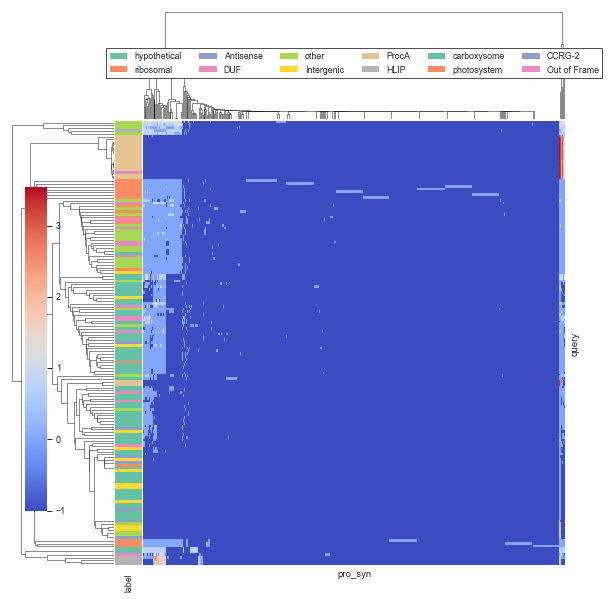

In [84]:
sns.set_context('paper')
blastn_vs_pro_df['log_hsps'] = np.log(blastn_vs_pro_df['pro_syn_hsps'])
pivotdf = blastn_vs_pro_df.loc[
    blastn_vs_pro_df['query'].isin(found_sorf_df['orfid'])
].pivot_table(columns=['pro_syn'], index='query', values=['log_hsps'],
                                      fill_value=-1, 
                                      ).droplevel(0,axis=1)
row_colors = row_col[pivotdf.index].map(col_pal)

g = sns.clustermap(data=pivotdf, cmap='coolwarm', row_colors=row_colors,
                  linewidths=0, xticklabels=False, yticklabels=False)



for label in row_col.unique():
    g.ax_col_dendrogram.bar(0, 0, color=col_pal[label],
                            label=label, linewidth=0)
g.ax_col_dendrogram.legend(loc="center", ncol=6)
g.cax.set_position([.15, .2, .03, .45])


In [85]:
pivotdf.shape

(159, 472)

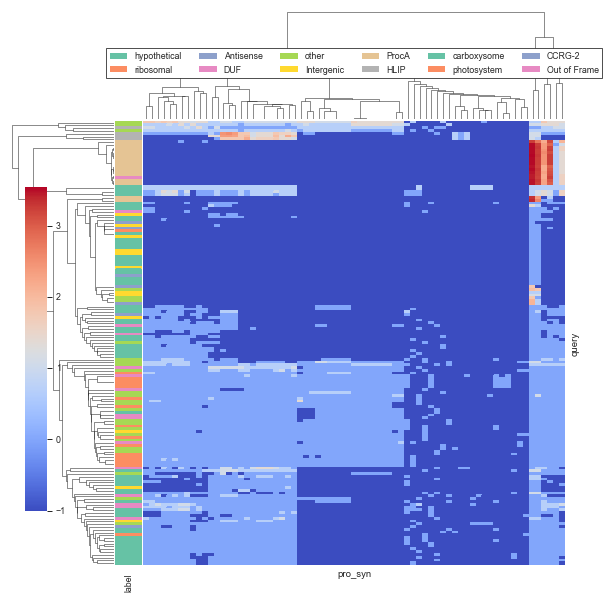

In [86]:
g = sns.clustermap(data=pivotdf.loc[:, (pivotdf >= 0).sum()>3], 
                   cmap='coolwarm', row_colors=row_colors,
                  linewidths=0, xticklabels=False, yticklabels=False, #standard_scale=0
                  )



for label in row_col.unique():
    g.ax_col_dendrogram.bar(0, 0, color=col_pal[label],
                            label=label, linewidth=0)
g.ax_col_dendrogram.legend(loc="center", ncol=6)
g.cax.set_position([.15, .2, .03, .45])


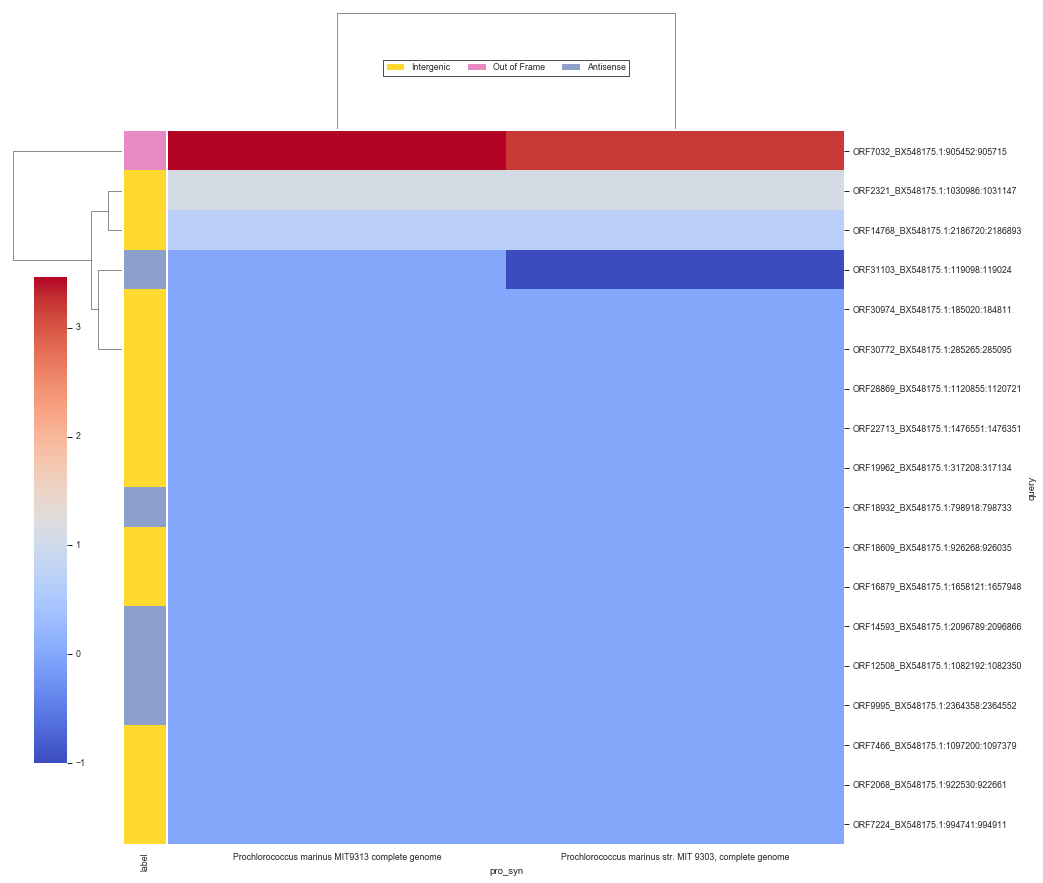

In [87]:
p = pivotdf.loc[found_sorf_df.loc[
    found_sorf_df.otype.isin(['Antisense', 'Out of Frame', 'Intergenic']), 'orfid']]
row_colors = row_col[p.index].map(col_pal)

g = sns.clustermap(data=p.loc[:, p.sum()>1], 
                   cmap='coolwarm', row_colors=row_col[p.index].map(col_pal), figsize=(15,15),
                  linewidths=0, #xticklabels=False, #yticklabels=False, #standard_scale=0
                  )



for label in row_col[p.index].unique():
    g.ax_col_dendrogram.bar(0, 0, color=col_pal[label],
                            label=label, linewidth=0)
g.ax_col_dendrogram.legend(loc="center", ncol=6)
g.cax.set_position([.15, .2, .03, .45])


In [88]:
pivotdf.head()

pro_syn,"A.nidulans ferredoxin (petF1) gene, complete cds","A.nidulans petF gene encoding ferredoxin I, complete cds",Anacystis nidulans R2 (= Synechococcus PCC7942) ferredoxin gene,Cyanobacterium Synechococcus 6301 DNA for ATP synthase subunits,Prochlorococcus marinus MED4 complete genome,Prochlorococcus marinus MIT9313 complete genome,Prochlorococcus marinus phycobiliprotein gene cluster,Prochlorococcus marinus psaF and psaJ genes,"Prochlorococcus marinus str. AS9601 clone A9601_07641 conserved hypothetical protein gene, complete cds","Prochlorococcus marinus str. AS9601 clone A9601_16291 conserved hypothetical protein gene, complete cds",...,"Uncultured Synechococcus sp. clone SOMLIT-ASTAN-05292012_envPBS_SC31 PBS region, partial sequence","Uncultured Synechococcus sp. clone SOMLIT-ASTAN-05292012_envPBS_SC5 PBS region, partial sequence","Uncultured marine type-A Synechococcus 4O4, partial genome fragment","Uncultured marine type-A Synechococcus 5B2, partial genome fragment",Uncultured marine type-A Synechococcus GOM 3M9 rbcL-containing genomic sequence,Uncultured marine type-A Synechococcus GOM 3O12 rbcL-containing genomic sequence,Uncultured marine type-A Synechococcus GOM 3O6 rbcL-containing genomic sequence,Uncultured marine type-A Synechococcus GOM 4N23 rbcL-containing genomic sequence,Uncultured marine type-A Synechococcus GOM 4P21 rbcL-containing genomic sequence,Uncultured marine type-A Synechococcus GOM 5D20 rbcL-containing genomic sequence
query,,,,,,,,,,,,,,,,,,,,,
ORF10855_BX548175.1:349523:349801,-1,-1,-1,-1,693.147E-03,693.147E-03,-1,-1,-1,-1,...,-1,-1,-1.000E+00,-1.000E+00,-1.000E+00,-1.000E+00,-1.000E+00,-1.000E+00,-1.000E+00,-1.000E+00
ORF11235_BX548175.1:514397:514681,-1,-1,-1,-1,-1.000E+00,0.000E+00,-1,-1,-1,-1,...,-1,-1,-1.000E+00,-1.000E+00,-1.000E+00,-1.000E+00,-1.000E+00,-1.000E+00,-1.000E+00,-1.000E+00
ORF11919_BX548175.1:807044:807238,-1,-1,-1,-1,0.000E+00,0.000E+00,-1,-1,-1,-1,...,-1,-1,-1.000E+00,-1.000E+00,-1.000E+00,-1.000E+00,-1.000E+00,-1.000E+00,-1.000E+00,-1.000E+00
ORF12155_BX548175.1:928784:929059,-1,-1,-1,-1,0.000E+00,693.147E-03,-1,-1,-1,-1,...,-1,-1,-1.000E+00,-1.000E+00,-1.000E+00,-1.000E+00,-1.000E+00,-1.000E+00,-1.000E+00,-1.000E+00
ORF12437_BX548175.1:1049864:1050085,-1,-1,-1,-1,-1.000E+00,0.000E+00,-1,-1,-1,-1,...,-1,-1,-1.000E+00,-1.000E+00,-1.000E+00,-1.000E+00,-1.000E+00,-1.000E+00,-1.000E+00,-1.000E+00


In [89]:
pivotdf.sum().sort_values().value_counts().sort_index()

-158.000E+00    369
-157.307E+00    1  
-157.000E+00    18 
-156.000E+00    6  
-155.614E+00    1  
               ..  
-22.015E+00     1  
 1.948E+00      1  
 16.721E+00     1  
 77.929E+00     1  
 90.163E+00     1  
Length: 61, dtype: int64

In [90]:
pivotdf.sum()>10

pro_syn
A.nidulans ferredoxin (petF1) gene, complete cds                                    False
A.nidulans petF gene encoding ferredoxin I, complete cds                            False
Anacystis nidulans R2 (= Synechococcus PCC7942) ferredoxin gene                     False
Cyanobacterium Synechococcus 6301 DNA for ATP synthase subunits                     False
Prochlorococcus marinus MED4 complete genome                                        False
                                                                                    ...  
Uncultured marine type-A Synechococcus GOM 3O12 rbcL-containing genomic sequence    False
Uncultured marine type-A Synechococcus GOM 3O6 rbcL-containing genomic sequence     False
Uncultured marine type-A Synechococcus GOM 4N23 rbcL-containing genomic sequence    False
Uncultured marine type-A Synechococcus GOM 4P21 rbcL-containing genomic sequence    False
Uncultured marine type-A Synechococcus GOM 5D20 rbcL-containing genomic sequence    False
Le

In [91]:
pivotdf.droplevel(0,axis=1).index

ValueError: Cannot remove 1 levels from an index with 1 levels: at least one level must be left.

In [ ]:
blastn_vs_pro_df.pro_syn_accession

In [ ]:
np.log(10)

In [ ]:
pivotdf.head()